### Author: Michael Polinsky

# Project 6: ANNs and Fetal Heart Monitoring

In [1]:
import pandas as pd
import numpy as np
import seaborn as sbn

from numpy import where

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter



from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, silhouette_score, silhouette_samples
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.svm import SVC, LinearSVC
from sklearn.cluster import KMeans, DBSCAN

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler, OneHotEncoder, binarize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten

### Importing the data from github

In [233]:
df = pd.read_csv("https://raw.githubusercontent.com/mpolinsky/AML/main/fetal_health.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

## 22 columns, all float64. 
## 11-20 are derived from a histogram
## 21 is the target.

### We have:

 - (baseline_value) fetal heart rate 
 - (accelerations) number of accelerations per second (of the heart?)
 - (fetal_movement) Number of fetal movements per second
 - (uterine_contractions) Number of uterine contractions per second
 - (light_decelerations)  Number of LDs per second
 - (severe_decelerations) Number of SDs per second
 - (prolongued_decelerations) Number of PDs per second
 - (abnormal_short_term_variability) Percentage of time with abnormal short term variability
 - (mean_value_of_short_term_variability) Mean value of short term variability
 - (percentage_of_time_with_abnormal_long_term_variability) Percentage of time with abnormal long term variability
 - (mean_value_of_long_term_variability) Mean value of long term variability
 - (histogram_width) Width of the histogram made using all values from a record
 - (histogram_min) Histogram minimum value
 - (histogram_max) Histogram maximum value
 - (histogram_number_of_peaks) Number of peaks in the exam histogram
 - (histogram_number_of_zeroes) Number of zeroes in the exam histogram
 - (histogram_mode) hist mode
 - (histogram_mean) hist mean
 - (histogram_median) hist median
 - (histogram_variance) hist variance
 - (histogram_tendency) hist tendency 
 - (fetal_health) 1. Normal 2. Suspect 3. Pathological

## After having difficulty with predicting 3 classes I decided to binarize the target, which I discuss more below.  I'm mentioning it here becuase I learned that binning can change correlation values, making some features appear more or less correlated.  The change is only due to the representation of the data, which will be essentially a lossier version of the original.

### The original target's correlation values

<AxesSubplot:>

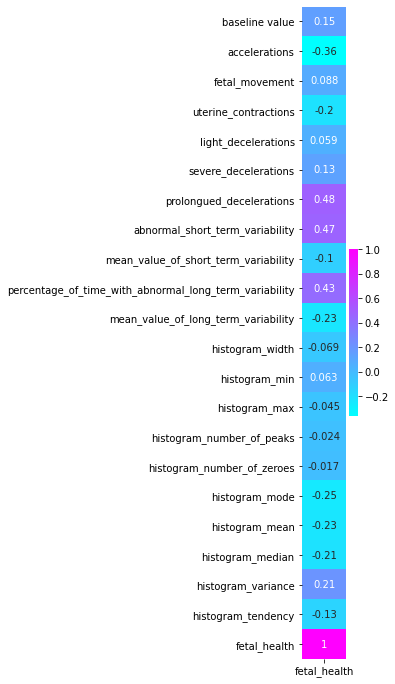

In [33]:
plt.figure(figsize=(1,12)) 
sbn.heatmap(pd.DataFrame(df.corr()['fetal_health']), cmap='cool', annot=True)

### The binarized target's values.

<AxesSubplot:>

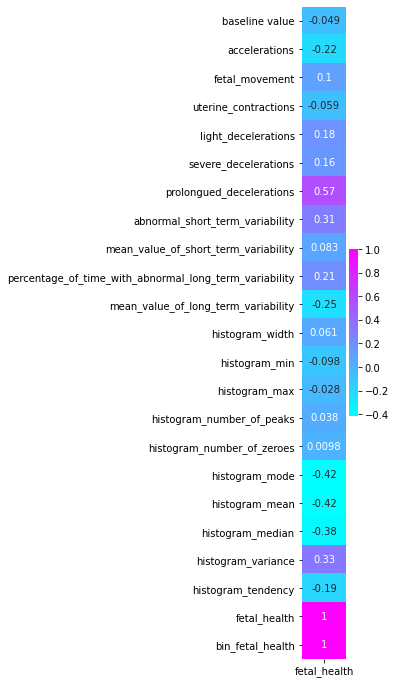

In [35]:
plt.figure(figsize=(1,12)) 
sbn.heatmap(pd.DataFrame(df.corr()['fetal_health']), cmap='cool', annot=True)

## I want to look more closely at the target.  How are the classes distributed?

<AxesSubplot:xlabel='fetal_health', ylabel='count'>

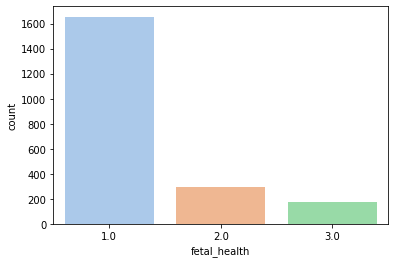

In [234]:
sbn.countplot(x=df.fetal_health, palette="pastel")

In [235]:
len(df[df.loc[:,'fetal_health']==1])

1655

In [236]:
len(df[df.loc[:,'fetal_health']==2])

295

In [237]:
len(df[df.loc[:,'fetal_health']==3])

176

In [238]:
( len(df[df.loc[:,'fetal_health']==3]) +  len(df[df.loc[:,'fetal_health']==2]) ) / len(df[df.loc[:,'fetal_health']==1])

0.2845921450151057

## 28% of target instances are in 2 of the classes, 72% in one class. That's quite uneven.  

array([[<AxesSubplot:title={'center':'baseline value'}>,
        <AxesSubplot:title={'center':'accelerations'}>,
        <AxesSubplot:title={'center':'fetal_movement'}>,
        <AxesSubplot:title={'center':'uterine_contractions'}>,
        <AxesSubplot:title={'center':'light_decelerations'}>],
       [<AxesSubplot:title={'center':'severe_decelerations'}>,
        <AxesSubplot:title={'center':'prolongued_decelerations'}>,
        <AxesSubplot:title={'center':'abnormal_short_term_variability'}>,
        <AxesSubplot:title={'center':'mean_value_of_short_term_variability'}>,
        <AxesSubplot:title={'center':'percentage_of_time_with_abnormal_long_term_variability'}>],
       [<AxesSubplot:title={'center':'mean_value_of_long_term_variability'}>,
        <AxesSubplot:title={'center':'histogram_width'}>,
        <AxesSubplot:title={'center':'histogram_min'}>,
        <AxesSubplot:title={'center':'histogram_max'}>,
        <AxesSubplot:title={'center':'histogram_number_of_peaks'}>],
      

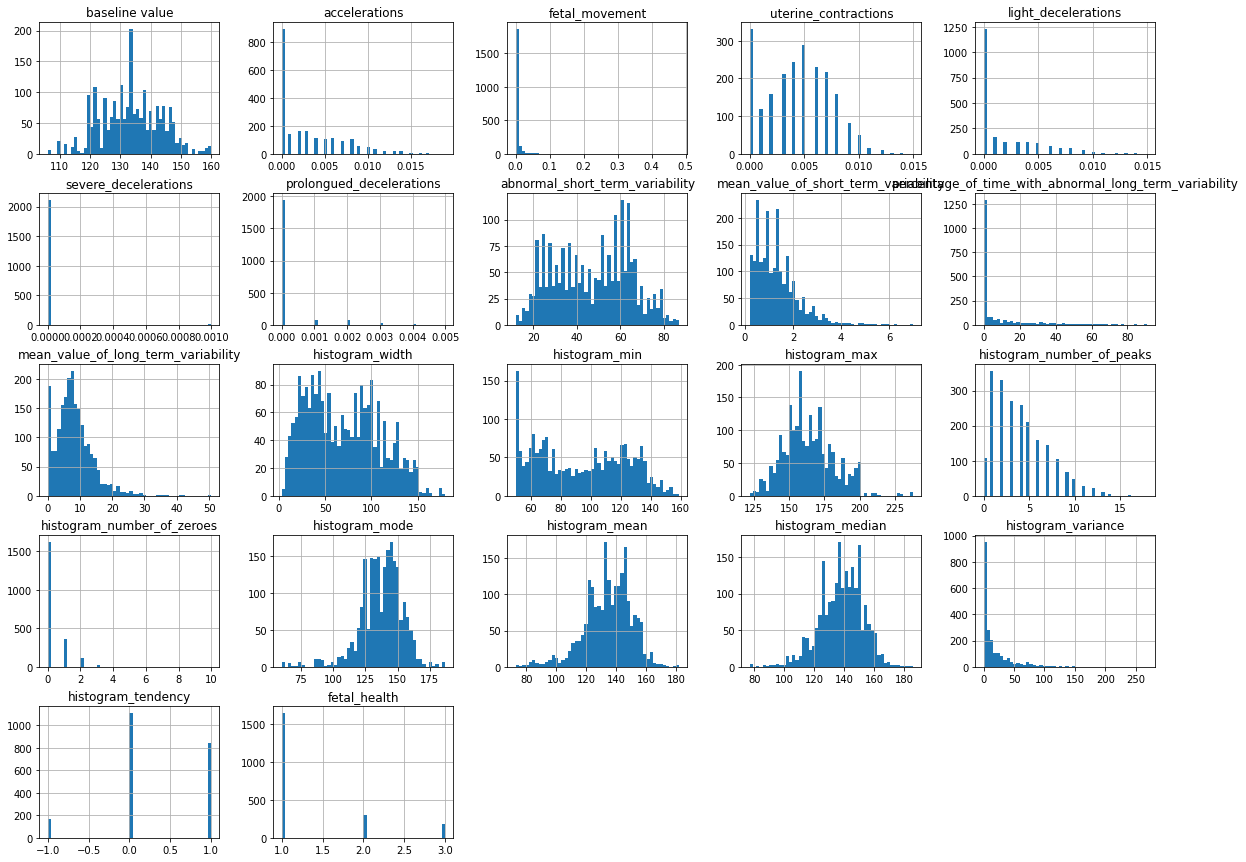

In [241]:
df.hist(bins=50, figsize=(20,15))

## I see several features that appear to have discrete values, possibly yes/no or values 1,2,3.  Some show some skewness but the StandardScaler should help.

## 137 records are 0 or about 6.5%.  I don't think that's enough to worry, and I don't have any reason to believe they're place-holders or missing values.

In [242]:
(len(df[df['mean_value_of_long_term_variability']==0]) / len(df['mean_value_of_long_term_variability'])) * 100

6.444026340545625

# I binned the histogram values to cross tabulate each with the binarized target classes.

## Rebin histogram measures where appropriate

In [250]:
bins = [0, 93, 133, 200]
labels = ['0', '1', '2']
df.loc[:,'binned_hist_mean'] = pd.cut(df.loc[:,'histogram_mean'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_hist_mean'] = df.loc[:,'binned_hist_mean'].astype(object)

In [251]:
bins = [0, 60, 120, 200]
labels = ['0', '1', '2']
df.loc[:,'binned_hist_width'] = pd.cut(df.loc[:,'histogram_width'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_hist_width'] = df.loc[:,'binned_hist_width'].astype(object)

In [252]:
bins = [0, 40, 80, 120, 160]
labels = ['40', '80', '120', '160']
df.loc[:,'binned_histogram_min'] = pd.cut(df.loc[:,'histogram_min'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_min'] = df.loc[:,'binned_histogram_min'].astype(object)

In [253]:
bins = [0, 150, 180, 210, 300]
labels = ['40', '80', '120', '160']
df.loc[:,'binned_histogram_max'] = pd.cut(df.loc[:,'histogram_max'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_max'] = df.loc[:,'binned_histogram_max'].astype(object)

In [254]:
bins = [0, 5, 10, 15, 21]
labels = ['0', '1', '2', '3']
df.loc[:,'binned_histogram_number_of_peaks'] = pd.cut(df.loc[:,'histogram_number_of_peaks'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_number_of_peaks'] = df.loc[:,'binned_histogram_number_of_peaks'].astype(object)

In [255]:
bins = [0, 50, 100, 150, 250]
labels = ['0', '1', '2', '3']
df.loc[:,'binned_histogram_mode'] = pd.cut(df.loc[:,'histogram_mode'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_mode'] = df.loc[:,'binned_histogram_mode'].astype(object)

In [256]:
bins = [0, 50, 100, 150, 250]
labels = ['0', '1', '2', '3']
df.loc[:,'binned_histogram_median'] = pd.cut(df.loc[:,'histogram_median'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_median'] = df.loc[:,'binned_histogram_median'].astype(object)

In [257]:
bins = [0, 10, 20, 30, 40, 50,1000]
labels = ['0', '1', '2', '3', '4', '5']
df.loc[:,'binned_histogram_variance'] = pd.cut(df.loc[:,'histogram_variance'], bins=bins, labels=labels, right=True)
df.loc[:,'binned_histogram_variance'] = df.loc[:,'binned_histogram_variance'].astype(object)

## Cross tabulate

<AxesSubplot:xlabel='bin_fetal_health'>

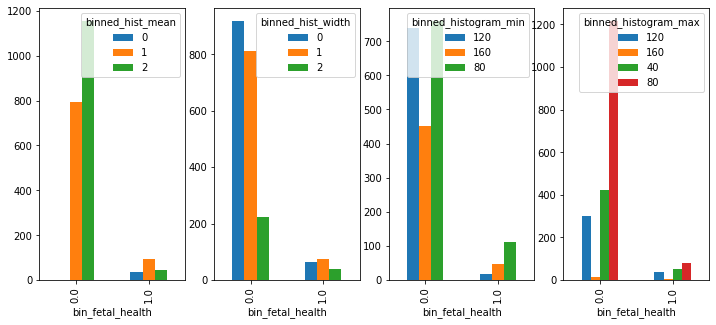

In [92]:
figure, axes = plt.subplots(1, 4)

ct0 = pd.crosstab(df['bin_fetal_health'], df['binned_hist_mean'])
ct0.plot.bar(ax = axes[0],figsize=(12,5))

ct1 = pd.crosstab(df['bin_fetal_health'], df['binned_hist_width'])
ct1.plot.bar(ax = axes[1],figsize=(12,5))

ct2 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_min'])
ct2.plot.bar(ax = axes[2], figsize=(12,5))

ct3 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_max'])
ct3.plot.bar(ax = axes[3], figsize=(12,5))

### There are some clear differences here but with so few labels for pathological or suspect cases vs healthy ones, it's a little tough to tell what part of these cross-tabulations show meaningful relationships.  I could say for the first graph, there don't seem to be any cases of binned-hist-mean = 0 for the 0 label, and that for the second graph there seem to be fewer cases of binned_hist_width = 2 for the 0 label than the 1.  Similarly, each of these features seems to vary in some way with the labels.

<AxesSubplot:xlabel='bin_fetal_health'>

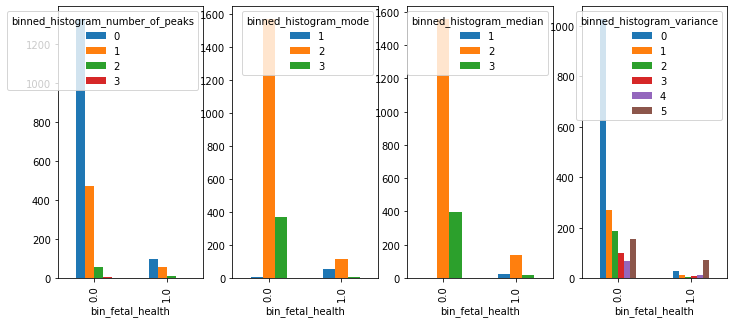

In [94]:
figure, axes = plt.subplots(1, 4)

ct4 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_number_of_peaks'])
ct4.plot.bar(ax = axes[0],figsize=(12,5))

ct5 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_mode'])
ct5.plot.bar(ax = axes[1],figsize=(12,5))

ct6 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_median'])
ct6.plot.bar(ax = axes[2], figsize=(12,5))

ct7 = pd.crosstab(df['bin_fetal_health'], df['binned_histogram_variance'])
ct7.plot.bar(ax = axes[3], figsize=(12,5))

### The same conclusion from above applies to these graphs, though I don't think binned_number_of_peaks shows any particular variation that's unique to the labels.  For all of these binned features, I would think that the method of binning can make a difference in how relevant the binned feature is.  I looked at the histogram of each feaure and decided how many bins to use, trying to keep it to 4 or 5 if it was reasonable.

#

## Resetting the data to drop those binned categories.  I experimented with using them to train the neural netowrks but they didn't seem to cause any improvement.  I'm also going to binarize the target to make this a simpler task for the network.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/mpolinsky/AML/main/fetal_health.csv")

<AxesSubplot:xlabel='fetal_health', ylabel='count'>

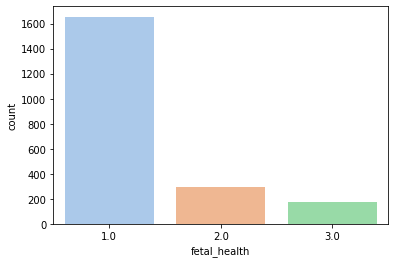

In [172]:
sbn.countplot(x=df.fetal_health, palette="pastel")

In [4]:
df.loc[:,'bin_fetal_health'] = binarize(df.loc[:,'fetal_health'].values.reshape(-1,1), threshold=1, copy=False)

## Here is the new binarized target.  Healthy is under label 0 and suspect/pathological goes under the label 1.

<AxesSubplot:xlabel='bin_fetal_health', ylabel='count'>

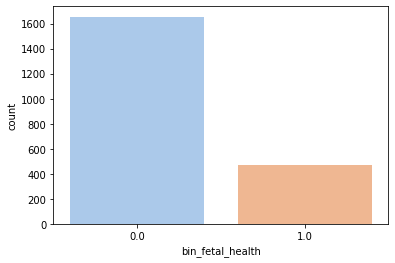

In [25]:
sbn.countplot(x=df.bin_fetal_health, palette="pastel")

## Create splits, scaling the data with a StandardScaler

In [6]:
X = df.drop(columns=['fetal_health', 'bin_fetal_health'])
Y = df.loc[:,'bin_fetal_health']
X2 = df2.drop(columns=['fetal_health', 'bin_fetal_health'])
Y2 = df2.loc[:,'bin_fetal_health'] 

In [7]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)


trainX, testX, trainY, testY = train_test_split(scaled_X, Y, train_size = 0.80, 
                                                      test_size = 0.20,
                                                      random_state = 101) 

trainX2, testX2, trainY2, testY2 = train_test_split(scaled_X, Y, train_size = 0.80, 
                                                      test_size = 0.20,
                                                      random_state = 101) 

# Model Training

In [274]:
# train a network with one hidden layer (50 nodes) and one output node
# too many hidden layers and nodes/hidden layer can cause overfitting
# experiment with these parameters to better observe the model behavior
model4 = keras.models.Sequential([keras.layers.Flatten(input_shape=[trainX.shape[1],]),
                                     keras.layers.Dense(12, activation="relu"), 
                                     keras.layers.Dense(30, activation="relu"), 
                                     keras.layers.Dense(8, activation="relu"), 
                                     keras.layers.Dense(2, activation="relu"), 
                                     keras.layers.Dense(2, activation="relu"), 
                                     keras.layers.Dense(1, activation="sigmoid") ])


In [278]:
# lets examine the model architecture

model4.summary()


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_61 (Flatten)         (None, 21)                0         
_________________________________________________________________
dense_442 (Dense)            (None, 12)                264       
_________________________________________________________________
dense_443 (Dense)            (None, 30)                390       
_________________________________________________________________
dense_444 (Dense)            (None, 8)                 248       
_________________________________________________________________
dense_445 (Dense)            (None, 2)                 18        
_________________________________________________________________
dense_446 (Dense)            (None, 2)                 6         
_________________________________________________________________
dense_447 (Dense)            (None, 1)               

In [275]:
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history4 = model4.fit(x=trainX, y=trainY, epochs=4500, batch_size=256, validation_data=(testX, testY), verbose=0)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [276]:
y_pred4 = (model4.predict(testX)).astype("int32")

cm4 = pd.DataFrame(confusion_matrix(testY, y_pred4))
print(classification_report(testY, y_pred4, labels=[0, 1]))

cm4

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       330
           1       0.98      0.58      0.73        96

    accuracy                           0.90       426
   macro avg       0.94      0.79      0.84       426
weighted avg       0.91      0.90      0.89       426



,0,1
0,329,1
1,40,56


# 

## This graph shows a fairly big divergence in loss between training and validation.  The accuracy suggests overfitting.

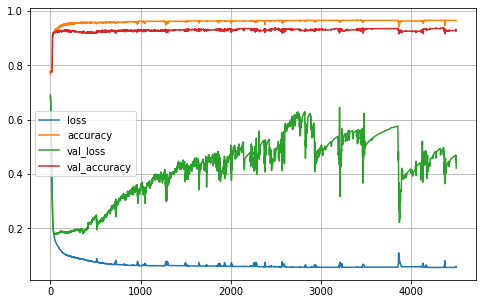

In [277]:
# plot model accuracy and loss during training
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()


#

## Earlier in my experimenting I created the following network and it turned out to be the best one I created, however, I realized that I had committed an off-by-one error and binned healthy/suspect under label 0 and pathological under label 1.  I didn't plot the accuracy ploss values at the time but I thought I would share it because it was able to almost eliminate false negatives, which would be useful for the medical situation where this would be used, which is in deciding whether or not to perform a c-section.  
### It also makes me wonder if the cases that were 'suspect' caused problems in the other binning, since the netowrk did so well on the pathological cases.

In [19]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[trainX.shape[1],]),
        keras.layers.Dense(12, activation="relu"),
        keras.layers.Dense(30, activation="relu"),
        keras.layers.Dense(20, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid")
])

In [65]:
y_pred = (model.predict(testX)).astype("int32")

print(confusion_matrix(testY, y_pred))
print(classification_report(testY, y_pred, labels=[0, 1]))

[[385   5]
 [  6  30]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       390
           1       0.86      0.83      0.85        36

    accuracy                           0.97       426
   macro avg       0.92      0.91      0.92       426
weighted avg       0.97      0.97      0.97       426



# 

## For the following section I used a different model architecture from above but got better results.  It's one of the architectures that emerged from experimentation.

# Hyperparameter Tuning

### This is the result of a grid search on the model below, searching different combinations of epochs and batch_size.  The best combination from the search was batch_size=256, epochs=4500.  In the model below I used 5500 epochs becuase a series of grid searches seemed to show that increasing the epochs would improve results and 4500 was just the highest value I'd tested.  Interestingly the batch_size went up and then back down as the epochs increased.

In [229]:
# cross validation in keras is somewhat different than in sklearn
# create the sequential NN model
def create_baseline():
    model = keras.models.Sequential([keras.layers.Flatten(), 
                                     keras.layers.Dense(12, activation="relu"),
                                     keras.layers.Dense(40, activation="relu"),
                                     keras.layers.Dense(8, activation="relu"),
                                     keras.layers.Dense(8, activation="relu"),
                                     keras.layers.Dense(2, activation="relu"),
                                     keras.layers.Dense(1, activation="sigmoid") ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=5500, batch_size=256, verbose=0)

# do a 3-fold CV on the entire dataset
kfold = StratifiedKFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, scaled_X, Y, cv=kfold)

print("Baseline accuracy: %.2f%% (+/- %.2f%%)" % (results.mean()*100, results.std()*100))



Baseline accuracy: 93.18% (+/- 1.33%)


In [230]:
nn_pred = (model.predict(testX) > 0.5).astype("int32")
nn_cm = confusion_matrix(y_true=testY, y_pred = nn_pred, labels = [0,1])
cm0 = pd.DataFrame(nn_cm)
print(classification_report(testY, y_pred, labels=[0,1]))
cm0

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       330
           1       1.00      0.64      0.78        96

    accuracy                           0.92       426
   macro avg       0.95      0.82      0.86       426
weighted avg       0.93      0.92      0.91       426



,0,1
0,321,9
1,14,82


## This is the grid search.  I ran several to arrive at this particular combination of features to search but I wasn't able to search through activation functions or numbers of nodes or layers.  It does seem possible, though sometimes it seems that using keras models in an sklearn wrapper can be tricky.

### This code came from a github page that I found after a lot of searching, but I haven't been able to locate since.  Lesson: bookmark such resources in the future.

In [293]:
# grid search epochs, batch size
epochs = [2500, 4500] # add 50, 100, 150 etc
batch_size = [256,512,1024] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size)
##############################################################
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(trainX, trainY) 
##############################################################
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.930588 using {'batch_size': 256, 'epochs': 4500}
0.922353 (0.012423) with: {'batch_size': 256, 'epochs': 2500}
0.930588 (0.009037) with: {'batch_size': 256, 'epochs': 4500}
0.918824 (0.014361) with: {'batch_size': 512, 'epochs': 2500}
0.915294 (0.015496) with: {'batch_size': 512, 'epochs': 4500}
0.910588 (0.018377) with: {'batch_size': 1024, 'epochs': 2500}
0.927647 (0.013491) with: {'batch_size': 1024, 'epochs': 4500}


# 

# Summary

### This task was about using keras neural networks on a set of data from fetal heart monitors.  I happen to live with my mother who is a recently retured pediatrician who has done these tests many times and was able to help me understand that these are done only during labor in cases where the mother or baby's health is already possibly at risk.  The target category 'pathological' means hypoxia, meaning that the baby isn't getting enough oxygen.  Unlike some medical uses for ML, the results of this test are used to make fairly immediate decisions about whether to proceed with a normal birth or perform a Caesarean section.  That procedure is not more unsafe than any routine surgical procedure but it may be something a mother wants to avoid for any number of reasons.  (Some women choose them in advance regardless of necessity.) The reason that matters is becuase I had to know what I was looking for in my model.  Due to an accident I originally got very good results separating out pathological cases (call them negative) with few false negatives and just a few false positives.  The problem is that false positives correspond to babies with hypoxia, for whom normal births are more dangerous, so really having minimal false positives would be a requirement for this to be used in delivery settings.  Additionally false negatives corespond to c-sections that might be unnecessary. When I rebinned the target so that the positve case corresponded to healthy and the negative to both suspect and pathological it was harder to get similar results to the first set of models.  That may have been due to the middle-ground nature of suspect cases.  

### Last semester was my first experience with neural networks and I remember having a very difficult time with them.  This time was moderately better.  Two features of NNs that I think I've learned now are that the randomization of weights means that unless I set a seed, my network will not give reproducible results.  I do wonder if a better model would have results that stay within a more reasonable range than I saw from single models.  I also noticed that networks with different architectures could yield similar confusion matrices which is interesting, and I even got similar results to my all relu network with an all tanh network that used a different number of layers and more nodes per layer.

### The grid search helped me to get the best results for the healthy vs suspect/pathological binarization and I just wish I could have gotten it to work for more parameters.

### I also trained an extra trees classifier and an rbf- kernel SVM and was able to get to 90% classification accuracy on both binarizations, and the confusion matrices were in line with what I was getting from my nerual networks.  I made an attempt to use the KerasClassifier-wrapped nerual network with the scikit VotingClassifier but ran into a series of errors and decided it wasn't important to the assignment and left it for another day.  Still it seems possible and I hope to work that out.  Below are the ExtraTrees and rbf-SVM classifiers.

# ExtraTrees and rbf-SVM

In [28]:
def cross_validate_model(classifier_model, X, y):
    kfold = KFold(n_splits=3, shuffle=True, random_state=10)

    # perform model cross validation on the shuffled folds
    results = cross_val_score(classifier_model, X, y, cv=kfold)

    # return the mean score for all folds
    return results.mean()

## Getting about 90% with XT

In [29]:
xt_clf = ExtraTreesClassifier(n_estimators=1000,     
                     criterion='gini',                     
                     max_depth=None,                   
                     n_jobs=None,                         
                     random_state=None,                     
                     verbose=0)                      

In [30]:
xt_trn_score = cross_validate_model(xt_clf, trainX, trainY)
xt_tst_score = cross_validate_model(xt_clf, testX, testY)
print(xt_trn_score)
print(xt_tst_score)

0.9341117156193716
0.9154929577464789


In [33]:
xt_pred = cross_val_predict(xt_clf, testX, testY, cv=3)
xt_cm = confusion_matrix(y_true=testY, y_pred = xt_pred, labels = [1,0])
cm1 = pd.DataFrame(xt_cm)
cm1

,0,1
0,72,24
1,7,323


In [34]:
xt_trn_score2 = cross_validate_model(xt_clf, trainX2, trainY2)
xt_tst_score2 = cross_validate_model(xt_clf, testX2, testY2)
print(xt_trn_score2)
print(xt_tst_score2)

0.9346996050961499
0.9178403755868545


In [35]:
xt_pred2 = cross_val_predict(xt_clf, testX2, testY2, cv=3)
xt_cm2 = confusion_matrix(y_true=testY2, y_pred = xt_pred2, labels = [1,0])
cm0 = pd.DataFrame(xt_cm2)
cm0

,0,1
0,70,26
1,8,322


## Getting about 88% with SVM/rbf

In [56]:
rbf_svc = SVC(kernel='poly',
              C=100.0,  
              degree=3,
              gamma='auto', 
              max_iter=- 1, 
              decision_function_shape='ovr', 
              random_state=None,
              verbose=10)

# unscaled scores: 
#       0.9622496911306301
#       0.9077509257374313

In [57]:
rbf_trn_score = cross_validate_model(rbf_svc, trainX, trainY)
rbf_tst_score = cross_validate_model(rbf_svc, testX, testY)
print(rbf_trn_score)
print(rbf_tst_score)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.9164687992720971
0.8873239436619719


In [58]:
rbf_pred = cross_val_predict(rbf_svc, testX, testY, cv=3)
rbf_cm = confusion_matrix(y_true=testY, y_pred = rbf_pred, labels = [1,0])
cm2 = pd.DataFrame(rbf_cm)
cm2

[LibSVM][LibSVM][LibSVM]

,0,1
0,72,24
1,23,307


In [59]:
rbf_trn_score2 = cross_validate_model(rbf_svc, trainX2, trainY2)
rbf_tst_score2 = cross_validate_model(rbf_svc, testX2, testY2)
print(rbf_trn_score2)
print(rbf_tst_score2)

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.9164687992720971
0.8873239436619719


In [60]:
rbf_pred2 = cross_val_predict(rbf_svc, testX2, testY2, cv=3)
rbf_cm2 = confusion_matrix(y_true=testY2, y_pred = rbf_pred2, labels = [1,0])
cm3 = pd.DataFrame(rbf_cm2)
cm3

[LibSVM][LibSVM][LibSVM]

,0,1
0,72,24
1,23,307
